In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load data

In [3]:
df = pd.read_csv('comments.csv',
                 usecols = ['rating', 'content'])
print(df['content'])

0         Có những người bước đến, họ lấp đầy hạnh phúc ...
1         Thấy nhiều bạn chê tiki gói hàng quá, may sao ...
2         Bìa cực xinh, tiki giao hàng nhanh, sách không...
3         Sách lúc nhận hình thức rất ổn, không cong vên...
4         Một cuốn sách rất đáng đọc về tình yêu thương ...
                                ...                        
141276                                                  NaN
141277                                        Tuyệt vời lắm
141278                                                  NaN
141279                                                  NaN
141280                                                  NaN
Name: content, Length: 141281, dtype: object


# Xử lý dữ liệu

In [4]:
print(f'Len of train dataset: {len(df)}')

Len of train dataset: 141281


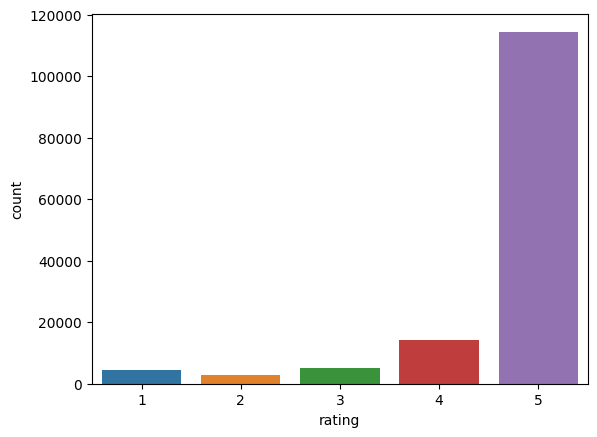

In [5]:
sns.countplot(x = df.rating);

### Missing Values

In [6]:
df.isna().sum()

rating         0
content    38018
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.shape

(103263, 2)

### Chia tập dữ liệu

In [9]:
X = df.content.copy()
y = df.rating.copy()

### Target

In [10]:
y = tf.keras.utils.to_categorical(y)

In [11]:
y.shape

(103263, 6)

### TPU

In [12]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.67.173.178:8470']
Number of accelerators:  8


# Xây dựng mô hình

In [ ]:
!pip3 install transformers

In [15]:
from transformers import TFAutoModel, AutoTokenizer

### Tạo Tokennizer

In [16]:
MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs),
                                                    y,
                                                    random_state=1905,
                                                    test_size=0.2,
                                                    shuffle=True)

In [18]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [19]:
# Build model
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)

    embedding = encoder(input_ids)[1]

    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    x = Dropout(0.2)(x)

    x = Dense(y.shape[1],
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)

    model = Model(inputs=[input_ids], outputs = x)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [21]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [22]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [23]:
# Train model
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1,
                    batch_size = 256)

Epoch 1/20
291/291 [==============================] - 333s 558ms/step - loss: 21.6872 - accuracy: 0.7699 - val_loss: 20.3649 - val_accuracy: 0.7982
Epoch 2/20
291/291 [==============================] - 101s 346ms/step - loss: 19.3252 - accuracy: 0.8083 - val_loss: 18.2925 - val_accuracy: 0.8159
Epoch 3/20
291/291 [==============================] - 101s 346ms/step - loss: 17.3665 - accuracy: 0.8189 - val_loss: 16.4487 - val_accuracy: 0.8179
Epoch 4/20
291/291 [==============================] - 100s 345ms/step - loss: 15.5988 - accuracy: 0.8263 - val_loss: 14.7743 - val_accuracy: 0.8218
Epoch 5/20
291/291 [==============================] - 100s 345ms/step - loss: 13.9897 - accuracy: 0.8335 - val_loss: 13.2443 - val_accuracy: 0.8264
Epoch 6/20
291/291 [==============================] - 101s 346ms/step - loss: 12.5246 - accuracy: 0.8369 - val_loss: 11.8538 - val_accuracy: 0.8299
Epoch 7/20
291/291 [==============================] - 100s 345ms/step - loss: 11.1822 - accuracy: 0.8442 - val_l

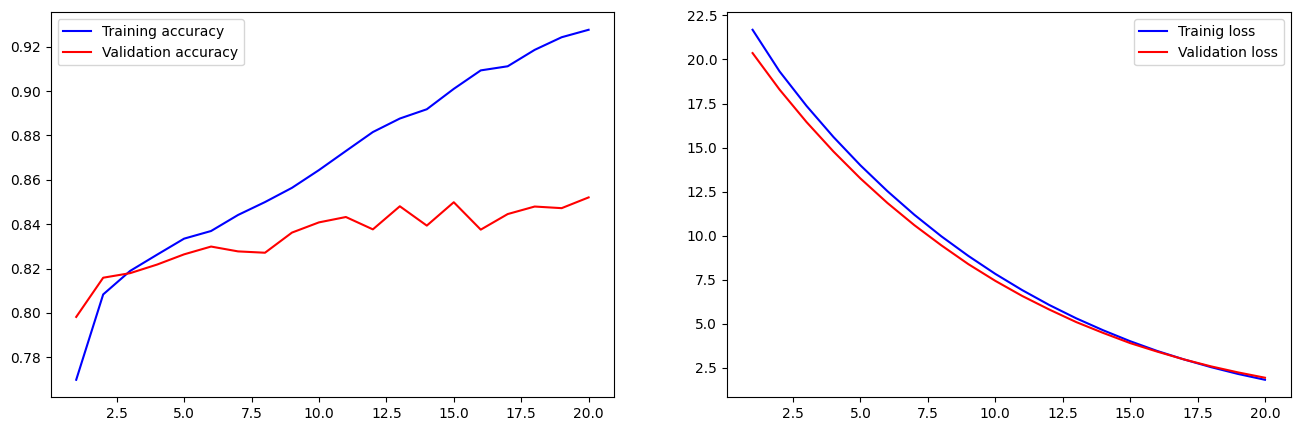

In [24]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
81/81 [==============================] - 14s 166ms/step - loss: 1.9142 - accuracy: 0.8543
test loss, test acc: [1.9141682386398315, 0.8543068766593933]
